# **Imports and Utils**

## Imports

In [2]:
# imports for the practice (you can add more if you need)
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
from PIL import Image
from google.colab import files
from tqdm import tqdm
import statistics
from nltk.translate.bleu_score import corpus_bleu

# libraries for dataset processing
import pandas as pd 
import spacy
import json

# pytorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchtext.legacy.data as data
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchvision.models as models
import torchtext
import torchvision
import torch.nn.functional as f
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset

# seed for results replication
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utils

### *Hyperparameters Class*

Makes keeping track of hyperparameters easier


In [3]:
class Hyperparameters:
    def __init__(self, embed_size, vocab_size, learning_rate, num_epochs, num_layers=1, hidden_size=256, attention_dim=256, encoder_dim=2048, decoder_dim=512):
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.attention_dim = attention_dim
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim

### *Convert Image to plot*

In [4]:
def convert_to_imshow_format(image):
 image = image.numpy()
 # convert from CHW to HWC
 return image.transpose(1,2,0)

### *Plot Attention weights over image*
*   `img` - Image to display.
*   `result` - Caption predicted by model.
*   `attention_plot` - Attention weights.
*   `save` - Saves figure to Colab `'\content'`.


In [5]:
def plot_attention(img, result, attention_plot, idx, save=False, dpi=None):    
    
    len_result = len(attention_plot)
    fig= plt.figure(figsize=(4*len_result//2, 4*len_result//2))
    
    for l in range(len_result):
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l+1])
        a = ax.imshow(img)
        temp_att = attention_plot[l].reshape(7,7)
        ax.imshow(temp_att, cmap='gray', alpha=0.5, extent=a.get_extent())
        ax.set_xticks([])
        ax.set_yticks([])

    #plt.tight_layout()
    
    if save:
      filename="attention%d" % (idx)
      plt.savefig(filename+".png", dpi=dpi)
      #files.download(filename+".png") 
    plt.show()  

### *Display images with model prediction caption*
*   `path` - Path for folder where images are.
*   `attention` - if the model uses Attention set to `True`.
*   `max_imgs` - Select amount of random images from the folder to be displayed.


In [6]:
def print_examples(model, device, dataset, path, transform, attention=False, save=False, max_imgs=5, dpi=None):
    model.eval()  
    img_files = np.array(os.listdir(path))
    
    num_images = len(img_files)
    
    if num_images > max_imgs:
      mask = np.zeros(num_images, dtype=int)
      mask[:max_imgs] = 1
      np.random.shuffle(mask)
      mask = mask.astype(bool)
      images = img_files[mask]
    else :
      images = img_files
    num_images = len(images)

    fig, axes = plt.subplots(num_images,1, figsize=(10,4*num_images))
    for idx, image_path in enumerate(images):
        input_path = os.path.join(path, image_path)
        test_img = Image.open(input_path).convert("RGB")
        axes[idx].imshow(test_img)
        if attention:
          caption, alphas = model.caption_image(transform(test_img).unsqueeze(0).to(device), dataset.vocab)
        else:
          caption = model.caption_image(transform(test_img).unsqueeze(0).to(device), dataset.vocab)
        axes[idx].set_title(" ".join(caption))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
    if save:
      plt.savefig("examples.png", dpi=dpi)    
    if attention:
      for idx, image_path in enumerate(images): 
        input_path = os.path.join(path, image_path)
        test_img = Image.open(input_path).convert("RGB")
        caption, alphas = model.caption_image(transform(test_img).unsqueeze(0).to(device), dataset.vocab)  
        plot_attention(test_img, caption, alphas, idx, save=save, dpi=dpi)

    model.train()

### *Save and load model checkpoint*

In [7]:
def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint_path, model, optimizer, device):
    print("=> Loading checkpoint")
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    return state["epoch"], state["losses"]

def load_hyperparams(checkpoint_path, device):
    state = torch.load(checkpoint_path, map_location=device)
    return state["hyperparams"]

### *Evaluate BLEU score*
*   `loader` - Loader for the data to evaluate from.
*   `model` - Model evaluated.
*   `num_batches` - Number of batches to consider when evaluating.
*   `multiple_ref` - If `True` then evaluates the BLEU score based on all the available captions each image from dataset.

In [8]:
def calc_bleu(loader, model, dataset, device ,path_images, path_captions,transform, attention=False, num_batches=None,multiple_ref=False):
    
    model.eval()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    keywords = ['<sos>', '<eos>', '<pad>']

    with torch.no_grad():
        # Batches
        for i, (imgs, caps, ids) in tqdm(
            enumerate(loader), total=len(loader), leave=True, position=0
        ):
            if num_batches == i:
              break
              
            caps = caps.permute(1,0)
            for j, im in enumerate(imgs):
              img = imgs[j].to(device)
              cap = caps[j].to(device)
              id = ids[j]
              refs = []
              if multiple_ref:
                ref_captions = captions_from_id(id, path_images, path_captions)
                for c in ref_captions:
                  ref = dataset.vocab.tokenizer_eng(c)
                  refs.append(ref)
              else:
                cap_txt = [dataset.vocab.itos[t.item()] for t in cap if dataset.vocab.itos[t.item()] not in keywords]
                refs.append(cap_txt)
              
              if attention:
                pred, _ = model.caption_image(img.unsqueeze(0), dataset.vocab)
              else:
                pred = model.caption_image(img.unsqueeze(0), dataset.vocab)

              pred_txt = [t for t in pred if t not in keywords]
              references.append(refs)
              hypotheses.append(pred_txt)  
        # Calculate BLEU scores
        bleu1 = corpus_bleu(references, hypotheses,weights=(1,0,0,0))
        bleu2 = corpus_bleu(references, hypotheses,weights=(0.5,0.5,0,0))
        bleu3 = corpus_bleu(references, hypotheses,weights=(1/3,1/3,1/3,0))
        bleu4 = corpus_bleu(references, hypotheses,weights=(0.25,0.25,0.25,0.25))

    model.train()
    return bleu1, bleu2, bleu3, bleu4


### *Retrieve all captions from given image file name*
*   `id` - Image file name.
*   `root_dir` - Directory for the images in dataset.
*   `captions_file` - File from dataset that contains the captions.

In [9]:
def captions_from_id(id,root_dir, captions_file):
  df = pd.read_csv(captions_file)
  imgs = df["image"].to_numpy()
  captions = df["caption"].to_numpy()
  selected = imgs == id
  return captions[selected]
  

# **Data Pre-Processing**

## *Vocabulary Class*

In [10]:
spacy_eng = spacy.load("en")
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]


## *Flickr8kDataset Class*

In [11]:
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, split='', test_size=0.1):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        # Get img, caption columns
        imgs_total = self.df["image"].to_numpy()
        captions_total = self.df["caption"].to_numpy()

        num_total = len(imgs_total)
        indices = list(range(num_total))
        split_idx = int(np.floor(test_size * num_total))
        np.random.shuffle(indices)
        train_idx, test_idx = indices[split_idx:], indices[:split_idx]

        imgs_train = imgs_total[train_idx]
        imgs_test = imgs_total[test_idx]

        captions_train = captions_total[train_idx]
        captions_test = captions_total[test_idx]

        if (split == 'train'):
          self.imgs = imgs_total
          self.captions = captions_total
        elif (split == 'test'):
          self.imgs = imgs_total
          self.captions = captions_total
        else:    
          self.imgs = imgs_total
          self.captions = captions_total

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<sos>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<eos>"])

        return img, torch.tensor(numericalized_caption), img_id


## *Loader Creator*

*   `root_folder` - Directory for the images in dataset.
*   `annotation_file` - File from dataset that contains the captions.
*   `split` - `'train'` for train set, `'test'` for test set, otherwise returns full dataset loader.

In [12]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        img_ids = [item[2] for item in batch]
        return imgs, targets, img_ids


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
    split='',
    test_size=0.1):
  
    dataset = Flickr8kDataset(root_folder, annotation_file, transform=transform, split=split, test_size=test_size)

    pad_idx = dataset.vocab.stoi["<pad>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


## *Download Flickr8k Dataset*


*   `api_token` - API Token from Kaggle User in order to download dataset.




In [13]:
!pip install kaggle
api_token = {"username":"ypurKaggleUsername","key":"yourKaggleAPIToken"}
!mkdir -p ~/.kaggle
with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k

kaggle.json
 99% 1.02G/1.04G [00:14<00:00, 89.2MB/s]
100% 1.04G/1.04G [00:15<00:00, 74.1MB/s]


## *Extract .zip File*

In [14]:
import zipfile
with zipfile.ZipFile('./flickr8k.zip', 'r') as zip_ref:
    zip_ref.extractall('./flickr8k')

## *Files Directories*

*   `path_images` - Directory for dataset images.
*   `path_captions` - Directory for dataset captions.
*   `path_examples` - Directory for sample images to display.
*   `path_checkpoints` - Directory for model checkpoints.



In [15]:
path_images="/content/flickr8k/Images"
path_captions="/content/flickr8k/captions.txt"
path_examples=""  #Images to caption
path_checkpoints="" #Model checkpoints

## *Display samples from dataset*
*   `path_images` - Directory for dataset images.
*   `path_captions` - Directory for dataset captions.

In [16]:
def display_samples(path_images, path_captions):
  display_transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        ])

  display_loader, display_dataset = get_loader(path_images,path_captions,batch_size=2,transform=display_transform)
  display_iter = iter(display_loader)
  images, captions, ids = display_iter.next()
  fig, axes = plt.subplots(len(images),1, figsize=(2.5,5))
  for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(" ".join([display_dataset.vocab.itos[t.item()] for t in captions[:,idx]]))
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

    

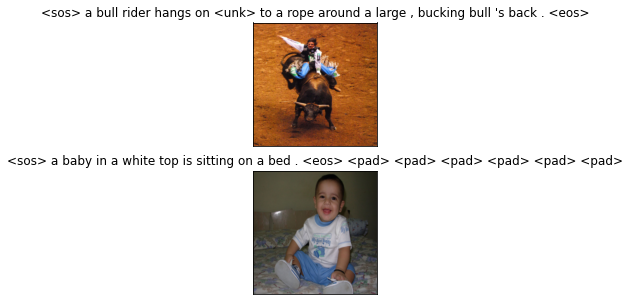

In [17]:
display_samples(path_images, path_captions)

# **Dataset Loaders**


## *Create Transform*

*   `split` - Default value is `train`.
*   `model` - `1` for Model 1, `2` for Model 2, default is `2`.


In [18]:
def create_transform(split='train', model=2):
  if model == 1: 
    if split == 'test':
      transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    else:
      transform = transforms.Compose([
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
  else:  
    if split == 'test':
      transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),])
    else:
      transform = transforms.Compose([
            transforms.Resize((226, 226)),
            transforms.RandomCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),])
      
  return transform   

## *Create Loader*
*   `path_images` - Directory for dataset images.
*   `path_captions` - Directory for dataset captions.
*   `split` - Default value is `train`.
*   `model` - `1` for Model 1, `2` for Model 2, default is `2`.



In [19]:
def create_loader(path_images, path_captions, split='', model=2):
  transform = create_transform(split, model)
  return get_loader(
        root_folder=path_images,
        annotation_file=path_captions,
        transform=transform,split=split)

In [20]:
transform_Inception_Test = create_transform(split='test', model=1)
transform_Inception_Train = create_transform(split='train', model=1)
transform_Resnet_Test = create_transform(split='test', model=2)
transform_Resnet_Train = create_transform(split='train', model=2)

train_loader_inception, train_dataset_inception = create_loader(path_images, path_captions, split='train', model=1)
train_loader_resnet, train_dataset_resnet = create_loader(path_images, path_captions, split='train', model=2)

total_loader_inception, total_dataset_inception = create_loader(path_images, path_captions, model=1)
total_loader_resnet, total_dataset_resnet = create_loader(path_images, path_captions, model=2)

test_loader_inception, test_dataset_inception = create_loader(path_images, path_captions, split='test', model=1)
test_loader_resnet, test_dataset_resnet = create_loader(path_images, path_captions, split='test', model=2)

# **Model 1**
CNN-RNN with Single layer LSTM without Attention


*   **Encoder** - Pre-Trained Inception v3
*   **Decoder** - Single Layer LSTM
* Inspired by 
https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/more_advanced/image_captioning

## *Model Definition*

In [21]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<eos>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

## *Train function*
*   `hyperparam` - Hyperparameters from the Hyperparameters Class.
*   `train_CNN` - If `True` then fine tunes the pre trained encoder.
*   `load_model` - If `True` then resumes training from checkpoint.
*   `save_model` - If `True` then saves checkpoints after each epoch.
*   `model_file` - Saves and loads checkpoints from directory `path_checkpoints+model_file`.

In [22]:
def train_LSTM_pretrained(train_loader, dataset, hyperparam , device, model_file='',save_model=True,train_CNN=False,load_model=False, cudnn_benchmark=True):

    torch.backends.cudnn.benchmark = cudnn_benchmark
    losses = []

    # Hyperparameters
    hyper = hyperparam
    if load_model: 
      hyper = load_hyperparams(path_checkpoints+model_file, device)
    
    embed_size = hyper.embed_size
    hidden_size = hyper.hidden_size
    vocab_size = hyper.vocab_size
    num_layers = hyper.num_layers
    learning_rate = hyper.learning_rate
    num_epochs = hyperparam.num_epochs

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<pad>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN
    
    start_epoch = 1
    if load_model:
        start_epoch, losses_loaded = load_checkpoint(path_checkpoints+model_file, model, optimizer, device)
        start_epoch += 1
        losses = losses_loaded
    model.train()
    
    for epoch in range(num_epochs+1)[start_epoch:]:
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)
        
        for idx, (imgs, captions,_) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=True, position=0
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
        losses.append(loss.item())
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "losses": losses,
                "hyperparams": hyper
            }
            save_checkpoint(checkpoint, path_checkpoints+model_file)    
        print(f"Epoch {epoch} - Loss = {loss.item()}")
    return losses

## *Train model and evaluate*

In [ ]:
LSTM_hyperparam = Hyperparameters(embed_size=256, hidden_size=256, vocab_size=len(train_dataset_inception.vocab), num_layers=1, learning_rate=3e-4, num_epochs=100)
losses_no_Attention = train_LSTM_pretrained(train_loader_inception, train_dataset_inception, LSTM_hyperparam, device, model_file="/LSTM_ckpt.pth", load_model=True)


In [ ]:
fig = plt.figure(figsize=(8, 5)) 
ax = fig.add_subplot(1, 1 ,1) 
ax.plot(range(len(losses_no_Attention))+np.ones(len(losses_no_Attention)),losses_no_Attention, label="Training Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel("Loss")
ax.set_title("Training Loss - No Attention")
ax.grid()
ax.legend() 

plt.savefig("loss_LSTM.png")

In [ ]:
LSTM_hyperparam = load_hyperparams(path_checkpoints+"/LSTM_ckpt.pth", device)
model = CNNtoRNN(LSTM_hyperparam.embed_size, LSTM_hyperparam.hidden_size, LSTM_hyperparam.vocab_size, LSTM_hyperparam.num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=LSTM_hyperparam.learning_rate)
load_checkpoint(path_checkpoints+"/LSTM_ckpt.pth", model, optimizer, device)
print_examples(model, device, test_dataset_inception,path_examples, transform_Inception_Test, attention=False, max_imgs=15, save=True)

In [ ]:
calc_bleu(total_loader_resnet,model, total_dataset_resnet, device, path_images, path_captions, transform_Inception_Test, attention=False, num_batches=20, multiple_ref=True)

# **Model 2**
CNN-RNN with Single layer LSTM with Soft Attention


*   **Encoder** - Pre-Trained ResNet50
*   **Decoder** - Single Layer LSTM with Soft Attention
* Inspired by
https://www.kaggle.com/mdteach/image-captioning-with-attention-pytorch


## *Model Definiton*

In [35]:
class EncoderResnet(nn.Module):
    def __init__(self):
        super(EncoderResnet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = f.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
                

class DecoderAttention(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<sos>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = [vocab.stoi["<sos>"]]
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the alpha score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <eos> detected
            if vocab.itos[predicted_word_idx.item()] == "<eos>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c                

class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,  encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderResnet()
        self.decoder = DecoderAttention(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        return self.decoder.generate_caption(self.encoder(image[0:1]), max_length, vocabulary)          

## *Train function*
*   `hyperparam` - Hyperparameters from the Hyperparameters Class.
*   `train_CNN` - If `True` then fine tunes the pre trained encoder.
*   `load_model` - If `True` then resumes training from checkpoint.
*   `save_model` - If `True` then saves checkpoints after each epoch.
*   `model_file` - Saves and loads checkpoints from directory `path_checkpoints+model_file`.

In [36]:
def train_Attention(train_loader, dataset, hyperparam , device ,model_file='',save_model=True,train_CNN=False,load_model=False, cudnn_benchmark=True):

    torch.backends.cudnn.benchmark = cudnn_benchmark
    losses = []

    # Hyperparameters
    hyper = hyperparam
    if load_model: 
      hyper = load_hyperparams(path_checkpoints+model_file, device)

    embed_size = hyper.embed_size
    vocab_size = hyper.vocab_size
    attention_dim = hyper.attention_dim
    encoder_dim = hyper.encoder_dim
    decoder_dim = hyper.decoder_dim
    learning_rate = hyper.learning_rate
    num_epochs = hyperparam.num_epochs

    # initialize model, loss etc
    model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<pad>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    if train_CNN:
      for param in model.EncoderResnet.resnet.parameters():
              param.requires_grad = True

    start_epoch = 1
    if load_model:
        start_epoch, losses_loaded = load_checkpoint(path_checkpoints+model_file, model, optimizer, device)
        start_epoch += 1
        losses = losses_loaded
    model.train()
    
    for epoch in range(num_epochs+1)[start_epoch:]:
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)
        
        for idx, (imgs, captions, _) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=True, position=0
        ):
            imgs = imgs.to(device)
            captions = captions.permute(1,0).to(device)

            outputs, attentions = model(imgs, captions )
            targets = captions[:,1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
        losses.append(loss.item())
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "losses": losses,
                "hyperparams": hyper
            }
            save_checkpoint(checkpoint, path_checkpoints+model_file)    
        print(f"Epoch {epoch} - Loss = {loss.item()}")
    return losses

## *Train model and evaluate*

In [ ]:
Attention_hyperparam = Hyperparameters(embed_size=300, vocab_size=len(train_dataset_resnet.vocab), learning_rate=3e-4, num_epochs=25,attention_dim=256, encoder_dim=2048,decoder_dim=512)
losses_Attention = train_Attention(train_loader_resnet, train_dataset_resnet, Attention_hyperparam, device,model_file="/Attention1_ckpt.pth", load_model=False)

In [ ]:
fig = plt.figure(figsize=(8, 5)) 
ax = fig.add_subplot(1, 1 ,1) 
ax.plot(range(len(losses_Attention))+np.ones(len(losses_Attention)),losses_Attention, label="Training Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel("Loss")
ax.set_title("Training Loss - With Attention")
ax.grid()
ax.legend() 

plt.savefig("loss_Attention.png")

In [ ]:
Attention_hyperparam = load_hyperparams(path_checkpoints+"/Attention_ckpt.pth", device)
model = EncoderDecoder(Attention_hyperparam.embed_size, Attention_hyperparam.vocab_size, Attention_hyperparam.attention_dim, Attention_hyperparam.encoder_dim, Attention_hyperparam.decoder_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=Attention_hyperparam.learning_rate)
_,losses_Attention = load_checkpoint(path_checkpoints+"/Attention_ckpt.pth", model, optimizer, device)
print_examples(model, device, train_dataset_resnet,path_examples, transform_Resnet_Test, attention=True, max_imgs=16, save=True)

In [ ]:
calc_bleu(total_loader_resnet,model, total_dataset_resnet, device, path_images, path_captions, transform_Resnet_Test, attention=True, num_batches=10, multiple_ref=False)